## IST718 Final Project<br/>
March 28, 2020<br/>
Tim Abrams<br/>
Telly Cooper<br/>
Ryan Fischer<br/>
Brian Hogan

In [57]:
#####################################################
####         Set up Python Environment           ####
#####################################################
## Set up Python Environment
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.plotting import scatter_matrix  # scatter plot matrix
from pandas import Series

import random as rn
import numpy as np

import os
from os import path
import pathlib
import re
import subprocess
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# Pip Install pyunpack and patool
# Install 7z exe from https://www.7-zip.org/download.html
from pyunpack import Archive
from scipy.stats import uniform  # for training-and-test split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn import metrics, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method
#Import svm model
from sklearn import svm


import xgboost as xgb
from catboost import CatBoostClassifier
#warnings.filterwarnings('ignore')


import statsmodels.formula.api as smf
import statsmodels.api as sm
import string

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
# Seaborn for plotting and styling
import seaborn as sn
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from PIL import Image

import lightgbm as lgb

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from mlxtend.frequent_patterns import apriori     # AR rules
from mlxtend.frequent_patterns import association_rules

# https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost
# https://www.kaggle.com/rohandx1996/recommendation-system-with-83-accuracy-lgbm
# https://www.kaggle.com/freshwater/basic-of-lgbm

In [51]:
#####################################################
####              Set up workspace               ####
#####################################################
#### Setup Workspace, import data and set key variables ####
os.chdir('C:\\Users\\tellycoo\\Documents\\Courses\\SYR\\IST718\\Final_Project\\')
dirVar = 'C:\\Users\\tellycoo\\Documents\\Courses\\SYR\\IST718\\Final_Project\\data'
#kaggle competitions download -c kkbox-music-recommendation-challenge

def setupEnv (dirVar):
    Archive('data/train.csv.7z').extractall(dirVar)
    Archive('data/test.csv.7z').extractall(dirVar)
    Archive('data/song_extra_info.csv.7z').extractall(dirVar)
    Archive('data/songs.csv.7z').extractall(dirVar)
    Archive('data/members.csv.7z').extractall(dirVar)
    df_songs = pd.read_csv('data/songs.csv', encoding = 'utf-8', na_values=['NaN'])
    df_song_extra_info = pd.read_csv('data/song_extra_info.csv', encoding = 'utf-8', na_values=['NaN'])
    df_members = pd.read_csv('data/members.csv', encoding = 'utf-8', na_values=['NaN'])
    #print(df_song_extra_info.shape)
    df_train = pd.read_csv('data/train.csv', encoding = 'utf-8', na_values=['NaN'])
    df_test = pd.read_csv('data/test.csv', encoding = 'utf-8', na_values=['NaN'])
    return df_songs, df_song_extra_info, df_members, df_train, df_test


In [52]:
#####################################################
####              Explore Raw Data               ####
#####################################################
#### Setup Workspace, import data and set key variables ####
def exploreData ():
    #print(dfVar.dtypes)
    ##print(dfVar.isna().sum())
    print(df_songs.dtypes)
    print(df_song_extra_info.dtypes)
    print(df_members.dtypes)
    print(df_train.dtypes)
    print(df_test.dtypes)
    return

In [53]:
# Unpack 7z
#df_songs, df_song_extra_info, df_members, df_train, df_test = setupEnv(dirVar)

In [42]:
#exploreData()

In [54]:
#####################################################
####   Create and clean the working dataframe    ####
#####################################################
def cleanData ():
    is_English =  df_songs['language']==52.0
    dfVar = df_songs[is_English]
    dfVar.reset_index(level=0, inplace=True)
    dfVar = dfVar.drop('index', axis=1)
    alphabet = string.ascii_letters+string.punctuation+" "
    dfVar = dfVar[~dfVar.artist_name.str.strip(alphabet).astype(bool)]
    dfVar = dfVar[~dfVar.artist_name.str.strip(alphabet).astype(bool)]
    dfVar = dfVar[~dfVar.composer.str.strip(alphabet).astype(bool)]
    dfVar = dfVar[~dfVar.lyricist.str.strip(alphabet).astype(bool)]
    dfVar.reset_index(level=0, inplace=True)
    
    dfTrain = pd.merge(dfVar, df_train, on='song_id')
    dfTrain = pd.merge(dfTrain, df_members, on='msno')
    dfTrain = dfTrain[['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'city', 'bd', 'registered_via', 'registration_init_time', 'expiration_date']]
    dfTrain.rename(columns = {'bd':'age'}, inplace = True) 
    dfTrain.registered_via = dfTrain.registered_via.astype(str)
    dfTrain.columns = dfTrain.columns.str.replace(' ', '_')

    dfTrain.dropna()
    dfTrain.registration_init_time = pd.to_datetime(dfTrain.registration_init_time, format='%Y%m%d', errors='ignore')
    dfTrain.expiration_date = pd.to_datetime(dfTrain.expiration_date, format='%Y%m%d', errors='ignore')
    dfTrain['registration_init_time'] = pd.to_datetime(dfTrain['registration_init_time'])
    dfTrain.expiration_date = pd.to_datetime(dfTrain.expiration_date)
    dfTrain['membership_days'] = (dfTrain['expiration_date'] - dfTrain['registration_init_time']).dt.days.astype(int)
    dfTrain = dfTrain.drop(['registration_init_time','expiration_date'], axis=1)    
    dfTrain.song_length = dfTrain.song_length / 100000
    train_shape = pd.DataFrame(dfTrain.shape).iloc[0][0]
    myList = dfTrain.isnull().sum()
    myList = pd.DataFrame(myList)
    myList.columns = ['NACount']
    myList['Attribute'] = myList.index
    myList['Percentage'] = myList['NACount']/train_shape * 100
    col = myList[myList['Percentage'] > 1].Attribute.tolist()
    dfTrain = dfTrain.drop(col, axis=1)
    dfTrain.to_csv('df_train_Raw.csv')

    dfTest = pd.merge(dfVar, df_test, on='song_id')
    dfTest = pd.merge(dfTest, df_members, on='msno')
    dfTest = dfTest[['id', 'msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'city', 'bd', 'registered_via', 'registration_init_time', 'expiration_date']]
    dfTest.rename(columns = {'bd':'age'}, inplace = True) 
    dfTest.dropna()   
    dfTest.registered_via = dfTest.registered_via.astype(str)
    dfTest.columns = dfTest.columns.str.replace(' ', '_')

    dfTest.registration_init_time = pd.to_datetime(dfTest.registration_init_time, format='%Y%m%d', errors='ignore')
    dfTest.expiration_date = pd.to_datetime(dfTest.expiration_date, format='%Y%m%d', errors='ignore')
    dfTest.registration_init_time = pd.to_datetime(dfTest.registration_init_time, format='%Y%m%d', errors='ignore')
    dfTest.expiration_date = pd.to_datetime(dfTest.expiration_date, format='%Y%m%d', errors='ignore')
    dfTest.registration_init_time = pd.to_datetime(dfTest.registration_init_time)
    dfTest.expiration_date = pd.to_datetime(dfTest.expiration_date)
    dfTest['membership_days'] = (dfTest['expiration_date'] - dfTest['registration_init_time']).dt.days.astype(int)
    dfTest = dfTest.drop(['registration_init_time','expiration_date'], axis=1)
    dfTest.song_length = dfTest.song_length / 100000
    dfTest = dfTest.drop(col, axis=1)
    dfTest.to_csv('df_test_Raw.csv')
    return dfTrain, dfTest



In [55]:
#df_train_clean, df_test_clean = cleanData()

## Feature Engineering

In [59]:
def age_clean(trainVar, testVar):
    # Review age values and statistics
    trainVar = trainVar[trainVar["age"] >= 15]
    trainVar = trainVar[trainVar["age"] < 55]
    testVar = testVar[testVar["age"] >= 15]
    testVar = testVar[testVar["age"] < 55]
    return trainVar, testVar

def various_clean(trainVar, testVar):
    #### This will drop "Various Artists" ####
    trainVar = trainVar[trainVar['artist_name'] != "Various Artists"]
    testVar = testVar[testVar['artist_name'] != "Various Artists"]
    return trainVar, testVar

In [60]:
'''
# number of times a song has been played before
_dict_count_song_played = {k: v for k, v in df_train_clean['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played[x]
    except KeyError:
        return 0
df_train_clean['count_song_played'] = df_train_clean['song_id'].apply(count_song_played).astype(np.int8)
#df_train_clean = df_train_clean[df_train_clean["count_song_played"] > 0]

# number of times a song has been played before
_dict_count_song_played = {k: v for k, v in df_test_clean['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played[x]
    except KeyError:
        return 0
    
df_test_clean['count_song_played'] = df_test_clean['song_id'].apply(count_song_played).astype(np.int8)
#df_test_clean = df_test_clean[df_test_clean["count_song_played"] > 0]
'''

In [61]:
'''
# number of times the artist has been played
_dict_count_artist_played = {k: v for k, v in df_train_clean['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    return _dict_count_artist_played[x]

df_train_clean['count_artist_played'] = df_train_clean['artist_name'].apply(count_artist_played).astype(np.int8)
#df_train_clean = df_train_clean[df_train_clean["count_artist_played"] > 0]


# number of times the artist has been played
_dict_count_artist_played = {k: v for k, v in df_test_clean['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    return _dict_count_artist_played[x]

df_test_clean['count_artist_played'] = df_test_clean['artist_name'].apply(count_artist_played).astype(np.int8)
#df_test_clean = df_test_clean[df_test_clean["count_artist_played"] > 0]
'''

In [62]:
#df_train_clean, df_test_clean = age_clean(df_train_clean, df_test_clean)
#df_train_clean, df_test_clean = various_clean(df_train_clean, df_test_clean)

In [63]:
#df_train_clean.to_csv('df_train_clean.csv')
#df_test_clean.to_csv('df_test_clean.csv')

## Explore the Data

In [12]:
train_filename = 'df_train_clean.csv'
test_filename = 'df_test_clean.csv'
df_train_clean = pd.read_csv(train_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)
df_test_clean = pd.read_csv(test_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)
df_train_clean.head()

,msno,song_id,source_system_tab,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,city,age,registered_via,membership_days,count_song_played,count_artist_played
57,OOmcE+1n4yhFsiuG+I7hDexso7uY9/H63AcW6XluilI=,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,my library,local-library,1,2.32629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,5,24,9,2197,14,-87
58,OOmcE+1n4yhFsiuG+I7hDexso7uY9/H63AcW6XluilI=,aeOifznSOpfhinNr3RJl29omc3HGrdMgiI8jdrxYpsw=,search,song,1,2.32917,465,Anders Nilsen,Anders Nilsen,Anders Nilsen,5,24,9,2197,19,21
59,OOmcE+1n4yhFsiuG+I7hDexso7uY9/H63AcW6XluilI=,rzNV1cnIgp/1bfcwbeomcnynCtGa2yk0wp5ZHrkeJJk=,my library,local-playlist,1,1.92574,1609,David Guetta,David Guetta| Giorgio Tuinfort| Nick van de Wall,Bebe Rexha| Nicki Minaj| Ester Dean| Sean Douglas,5,24,9,2197,-124,-17
60,OOmcE+1n4yhFsiuG+I7hDexso7uY9/H63AcW6XluilI=,LufUuQQ4DSqPcKzSIH7aS5p+HL80Uxllvq9TfYXLwCs=,my library,local-playlist,1,1.84381,1609,Calvin Harris,Alessandro Lindblad/Theo Hutchcraft/Calvin Harris,Alessandro Lindblad/Theo Hutchcraft/Calvin Harris,5,24,9,2197,-57,49
61,OOmcE+1n4yhFsiuG+I7hDexso7uY9/H63AcW6XluilI=,+LztcJcPEEwsikk6+K5udm06XJQMzR4+lzavKLUyE0k=,my library,local-playlist,1,2.08492,1609,The Chainsmokers,Andrew Taggart| Emily Warren| Scott Harris,Andrew Taggart| Emily Warren| Scott Harris,5,24,9,2197,-12,79


## Explore the Data Decision Tree Analysis

In [64]:
mydata = pd.read_csv('decisiontree_mytrain.csv').fillna(0)
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
target                   1048575 non-null int64
msno_id                  1048575 non-null int64
song_id                  1048575 non-null int64
source_system_id         1048575 non-null float64
source_screen_name_id    1048575 non-null int64
source_type              1048575 non-null float64
song_length              1048575 non-null int64
genre_ids                1048575 non-null object
artist_name              1048575 non-null object
composer                 1048575 non-null object
lyricist                 1048575 non-null object
city                     1048575 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 96.0+ MB


In [65]:
# employ training-and-test regimen for model validation
mydata['artist_name'] = mydata['artist_name'].str.strip()
mydata['composer'] = mydata['composer'].str.strip()
mydata['genre_ids'] = mydata['genre_ids'].str.strip()
mydata['lyricist'] = mydata['lyricist'].str.strip()
#need yto string the genre IDs as had more than one in a category
mydata["genre_ids"]= mydata["genre_ids"].str.split("|", n = 1, expand = True) 
#get rid missing any genre_ids
len(mydata)  #original df sizde = 1048575
mydata.dropna(axis=0, subset=['genre_ids'], inplace=True)   #get rid any nan
len(mydata)  #1043630
# converting dtypes using astype
mydata["genre_ids"]= mydata["genre_ids"].astype(int)

np.random.seed(4444)
mydata['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(mydata))
mytrain = mydata[mydata['runiform'] >= 0.33]
mytest = mydata[mydata['runiform'] < 0.33]
# check training data frame

mytrain.columns

Index(['target', 'msno_id', 'song_id', 'source_system_id',
       'source_screen_name_id', 'source_type', 'song_length', 'genre_ids',
       'artist_name', 'composer', 'lyricist', 'city', 'runiform'],
      dtype='object')

In [66]:
# check correlations
mytrain_var = mytrain.loc[ : ,['target', 'song_id','source_system_id', \
    'source_screen_name_id', 'source_type', 'song_length', 'genre_ids', \
     'city']]
print(mytrain_var.corr())

                         target   song_id  source_system_id  \
target                 1.000000 -0.007637          0.007766   
song_id               -0.007637  1.000000          0.005064   
source_system_id       0.007766  0.005064          1.000000   
source_screen_name_id -0.049074 -0.000338          0.171811   
source_type           -0.113832  0.004882          0.007896   
song_length           -0.026634  0.009112          0.022594   
genre_ids             -0.003398  0.012925         -0.066788   
city                   0.002826 -0.000330         -0.018821   

                       source_screen_name_id  source_type  song_length  \
target                             -0.049074    -0.113832    -0.026634   
song_id                            -0.000338     0.004882     0.009112   
source_system_id                    0.171811     0.007896     0.022594   
source_screen_name_id               1.000000     0.133869     0.017685   
source_type                         0.133869     1.000000     

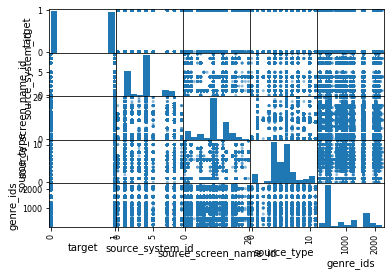

In [67]:
# scatter plot matrix (splom) demonstration
mytrain_splom_vars = mytrain.loc[ : ,['target', 'source_system_id',\
    'source_screen_name_id', 'source_type','genre_ids']]
scatter_matrix(mytrain_splom_vars)   
plt.show()

In [68]:
"""DECISION TREE"""
tree_model_maker = DecisionTreeRegressor(random_state = 9999, max_depth = 5)
y_train = mytrain.loc[:, ['target']]

X_train_simple = mytrain.loc[:, \
    ['source_system_id','source_screen_name_id', 'source_type' , \
     'song_length', 'genre_ids', 'city']]

X_test_simple = mytest.loc[:, \
    ['source_system_id','source_screen_name_id', 'source_type' , \
     'song_length', 'genre_ids', 'city']]

tree_model_fit = tree_model_maker.fit(X_train_simple, y_train)
tree_model_fit

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=9999, splitter='best')

In [69]:
# compute proportion of response variance for training data
mytrain['predict_target']=tree_model_fit.predict(X_train_simple)
    
full_tree_train_result = \
    round(np.power(mytrain['target']\
        .corr(mytrain['predict_target']),2),3)
    
print('\nFull Tree Proportion of Training Set Variance Accounted for: ',\
    full_tree_train_result)

# compute the proportion of response variance for test data
mytest['predict_target'] =tree_model_fit.predict(X_test_simple)
full_tree_test_result = \
    round(np.power(mytest['target']\
        .corr(mytest['predict_target']),2),3)
print('\nFull Tree Proportion of Test Set Variance Accounted for: ',\
    full_tree_test_result)


Full Tree Proportion of Training Set Variance Accounted for:  0.082

Full Tree Proportion of Test Set Variance Accounted for:  0.082


C:\Users\tellycoo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tellycoo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [70]:
""" CODE FOR GENERATING A TREE VISUAL
exports to word then have to use an app to build"""
# import export_graphviz 
from sklearn.tree import export_graphviz  
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
export_graphviz(tree_model_maker, out_file ='tree.dot',feature_names = \
            ['source_system_id','source_screen_name_id', 'source_type' , \
     'song_length', 'genre_ids', 'city'])

## Explore the Data Association Rules

In [71]:
# OBTAIN 
df0 = pd.read_csv('df_train_clean.csv').fillna(0)
#df0 = pd.read_csv('df_wsdm.csv')
df0.head()
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193957 entries, 0 to 193956
Data columns (total 17 columns):
Unnamed: 0             193957 non-null int64
msno                   193957 non-null object
song_id                193957 non-null object
source_system_tab      193957 non-null object
source_type            193957 non-null object
target                 193957 non-null int64
song_length            193957 non-null float64
genre_ids              193957 non-null object
artist_name            193957 non-null object
composer               193957 non-null object
lyricist               193957 non-null object
city                   193957 non-null int64
age                    193957 non-null int64
registered_via         193957 non-null int64
membership_days        193957 non-null int64
count_song_played      193957 non-null int64
count_artist_played    193957 non-null int64
dtypes: float64(1), int64(8), object(8)
memory usage: 25.2+ MB


In [72]:
#Inspection on size & planning for data assembly
num_songs_max = df0.groupby('msno')['song_id'].max()
len(num_songs_max)
print(num_songs_max)
num_songs_describe = df0.groupby('msno').genre_ids.describe()

msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=    zb9H8di4dyNqsm4j+ciXepLXije5GYhT6WW3w46CXo0=
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=    eBpnCE2GsAWi6UCz0EGWY5ozx8Sotcvkm/77kXfMi04=
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=    zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=
+/vppV5BoMKMNAk7Bej5rjhKeE6VqrRjUv8EYXoAjyM=    iuJkxwsMWYQYfkQhGOZbNPAOyjhmvSFWNQ6cIifZ4Mg=
                                                                    ...                     
zxyFUnD5Dxv8HMn9Ric1Qp6Q2WfvTpT270Ot6zj/7TI=    SEXmGAIKrBLJvU2yqL7G0KUkKq81WgLwrzy/GHyPjYE=
zy1OTzCnxegYltHBw1D1pZ8OH41xuwN+N6a+YMB0pwk=    zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=
zyCQN/h38OmzYOsR6ecE+b7GFkO2eCHoxT1tXoFdUjA=    zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=    zHqZ07gn+YvF36FWzv9+y8KiCMhYhdAUS+vSIKY3UZY=
zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=    qm1G/0r9ZHsHskGuh

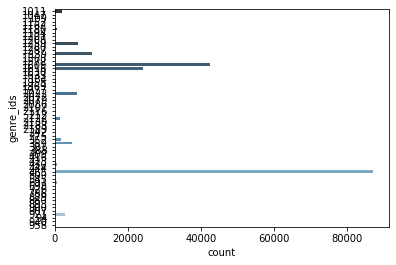

In [74]:
# SCRUB data with some minor transformations
#==> remove whitespace
#==> string split as multiple genre Ids
#==> get rid of extreme values

len(df0)  #original df sizde = 1692130
df0['artist_name'] = df0['artist_name'].str.strip()
df0['composer'] = df0['composer'].str.strip()
df0['genre_ids'] = df0['genre_ids'].str.strip()
#need yto string the genre IDs as had more than one in a category
df0["genre_ids"]= df0["genre_ids"].str.split("|", n = 1, expand = True) 
#get rid missing any genre_ids
df0.dropna(axis=0, subset=['genre_ids'], inplace=True)   
len(df0)  #1684592

"""WORK TO GET RID EXTREME VALUES """
#==> 
sn.countplot(y="genre_ids", data=df0, palette="Blues_d")
plt.show()
#print(df0.groupby('genre_ids')['genre_ids'].sum())
#df0.sort_values(by=['col1'])

In [76]:
"""######FINAL BASKET"""
#now make the baseket
basket = (df0.groupby(['msno','genre_ids'])['genre_ids']
          .count().unstack().reset_index().fillna(0)
          .set_index('msno'))
basket.head()
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10033 entries, ++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= to zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=
Data columns (total 61 columns):
1011    10033 non-null float64
1047    10033 non-null float64
109     10033 non-null float64
1152    10033 non-null float64
1162    10033 non-null float64
1180    10033 non-null float64
1194    10033 non-null float64
1201    10033 non-null float64
1208    10033 non-null float64
1259    10033 non-null float64
1280    10033 non-null float64
1287    10033 non-null float64
139     10033 non-null float64
1568    10033 non-null float64
1572    10033 non-null float64
1609    10033 non-null float64
1616    10033 non-null float64
1630    10033 non-null float64
1633    10033 non-null float64
184     10033 non-null float64
1955    10033 non-null float64
1969    10033 non-null float64
1977    10033 non-null float64
2022    10033 non-null float64
2072    10033 non-null float64
2079    10033 non-null float64
2086    

In [77]:
#CORRECT ENCODING FOR APRIORI | 0 and 1
def encode_units(x):   
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
df_output = pd.DataFrame(basket_sets) ## inspection
df_output.info()

#"""BACKUP of final data set"""
#df_output = pd.DataFrame(basket_sets) ## inspection
#output_data = df_output  #output the total tweet datatable
#output_data.to_csv("basket_sets_FINAL_9PM.csv", index=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10033 entries, ++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= to zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=
Data columns (total 61 columns):
1011    10033 non-null int64
1047    10033 non-null int64
109     10033 non-null int64
1152    10033 non-null int64
1162    10033 non-null int64
1180    10033 non-null int64
1194    10033 non-null int64
1201    10033 non-null int64
1208    10033 non-null int64
1259    10033 non-null int64
1280    10033 non-null int64
1287    10033 non-null int64
139     10033 non-null int64
1568    10033 non-null int64
1572    10033 non-null int64
1609    10033 non-null int64
1616    10033 non-null int64
1630    10033 non-null int64
1633    10033 non-null int64
184     10033 non-null int64
1955    10033 non-null int64
1969    10033 non-null int64
1977    10033 non-null int64
2022    10033 non-null int64
2072    10033 non-null int64
2079    10033 non-null int64
2086    10033 non-null int64
2107    10033 non-null int64
21

In [78]:
""" ANALYZE    TOP RULES GENERATED"""
basket_sets.info()
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 10033 entries, ++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU= to zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=
Data columns (total 61 columns):
1011    10033 non-null int64
1047    10033 non-null int64
109     10033 non-null int64
1152    10033 non-null int64
1162    10033 non-null int64
1180    10033 non-null int64
1194    10033 non-null int64
1201    10033 non-null int64
1208    10033 non-null int64
1259    10033 non-null int64
1280    10033 non-null int64
1287    10033 non-null int64
139     10033 non-null int64
1568    10033 non-null int64
1572    10033 non-null int64
1609    10033 non-null int64
1616    10033 non-null int64
1630    10033 non-null int64
1633    10033 non-null int64
184     10033 non-null int64
1955    10033 non-null int64
1969    10033 non-null int64
1977    10033 non-null int64
2022    10033 non-null int64
2072    10033 non-null int64
2079    10033 non-null int64
2086    10033 non-null int64
2107    10033 non-null int64
21

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1011),(139),0.095385,0.397987,0.072860,0.763845,1.919274,0.034898,2.549234
1,(139),(1011),0.397987,0.095385,0.072860,0.183070,1.919274,0.034898,1.107335
2,(1011),(1609),0.095385,0.738064,0.090501,0.948798,1.285522,0.020101,5.115763
3,(1609),(1011),0.738064,0.095385,0.090501,0.122620,1.285522,0.020101,1.031041
4,(1011),(1616),0.095385,0.713545,0.085916,0.900731,1.262333,0.017855,2.885654
5,(1616),(1011),0.713545,0.095385,0.085916,0.120408,1.262333,0.017855,1.028448
6,(1011),(465),0.095385,0.846905,0.093790,0.983281,1.161028,0.013008,9.156982
7,(465),(1011),0.846905,0.095385,0.093790,0.110745,1.161028,0.013008,1.017273
8,(1259),(139),0.246487,0.397987,0.166052,0.673676,1.692709,0.067954,1.844832
9,(139),(1259),0.397987,0.246487,0.166052,0.417230,1.692709,0.067954,1.292986


In [79]:
""" Dupstep is a form of techo beat music
Top Rules	antecedents	consequents	antecedent support	consequent support	support	confidence	lift
0	Country	    HipHop	    0.347539634	0.588840848	0.301461808	0.867417062	1.473092541
1	HipHop	    Country	    0.588840848	0.347539634	0.301461808	0.511958042	1.473092541
2	Country	Contemporary	0.347539634	0.518797612	0.281737698	0.810663507	1.562581417
3	Contemporary	Country	0.518797612	0.347539634	0.281737698	0.543058973	1.562581417
4	Country	    Dupstep	    0.347539634	0.696191064	0.318632901	0.916824645	1.316915271
5	Dupstep	    Country	    0.696191064	0.347539634	0.318632901	0.457680251	1.316915271
6	Country	    Electronic	0.347539634	0.557092856	0.278402306	0.801066351	1.437940448
7	Electronic	Country	    0.557092856	0.347539634	0.278402306	0.499741296	1.437940448
8	Country	Pop Rock	    0.347539634	0.471607988	0.253325098	0.728909953	1.545584406
9	Pop Rock	Country	    0.471607988	0.347539634	0.253325098	0.537151838	1.545584406
"""

' Dupstep is a form of techo beat music\nTop Rules\tantecedents\tconsequents\tantecedent support\tconsequent support\tsupport\tconfidence\tlift\n0\tCountry\t    HipHop\t    0.347539634\t0.588840848\t0.301461808\t0.867417062\t1.473092541\n1\tHipHop\t    Country\t    0.588840848\t0.347539634\t0.301461808\t0.511958042\t1.473092541\n2\tCountry\tContemporary\t0.347539634\t0.518797612\t0.281737698\t0.810663507\t1.562581417\n3\tContemporary\tCountry\t0.518797612\t0.347539634\t0.281737698\t0.543058973\t1.562581417\n4\tCountry\t    Dupstep\t    0.347539634\t0.696191064\t0.318632901\t0.916824645\t1.316915271\n5\tDupstep\t    Country\t    0.696191064\t0.347539634\t0.318632901\t0.457680251\t1.316915271\n6\tCountry\t    Electronic\t0.347539634\t0.557092856\t0.278402306\t0.801066351\t1.437940448\n7\tElectronic\tCountry\t    0.557092856\t0.347539634\t0.278402306\t0.499741296\t1.437940448\n8\tCountry\tPop Rock\t    0.347539634\t0.471607988\t0.253325098\t0.728909953\t1.545584406\n9\tPop Rock\tCountry\t

In [80]:
#Graphing & Analysis
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ] #very strong scale 0-1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


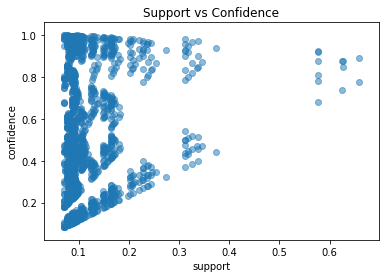

In [81]:
#Support vs Confidence
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

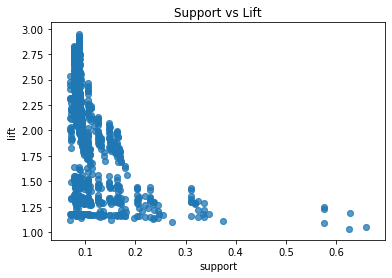

In [82]:
#support vs Lift
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

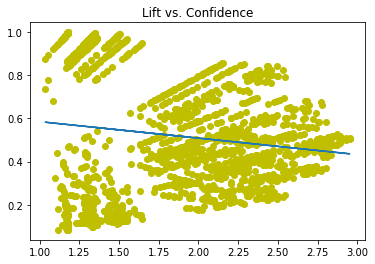

In [83]:
#lIFT vs confidence
import numpy as np
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.title("Lift vs. Confidence")
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))

## Explore the Data Visualizations

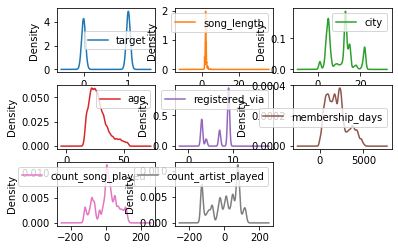

In [37]:
df_train_clean.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

In [61]:
df = df_train_clean.copy()
df['city'] = df['city'].astype(object)
df['registered_via'] = df['registered_via'].astype(object)
df.dtypes

msno                    object
song_id                 object
source_system_tab       object
source_type             object
target                   int64
song_length            float64
genre_ids               object
artist_name             object
composer                object
lyricist                object
city                    object
age                      int64
registered_via          object
membership_days          int64
count_song_played        int64
count_artist_played      int64
dtype: object

In [63]:
#df = df.reindex(columns= ['msno', 'age', 'song_id', 'artist_name', 'genre_ids', 'song_length', 'source_system_tab','source_type', 'city', 'registered_via', 'registration_init_time', 'expiration_date', 'target'])
#df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
#df.expiration_date = pd.to_datetime(df.expiration_date, format='%Y%m%d', errors='ignore')
#print(df_WIP.dtypes)

#df.dtypes

In [64]:
## Summary Tables
art_tab, src_tab, gen_tab, song_tab = [], [], [], []
#table = df.groupby(['artist_name'])['artist_name'].agg(['count']) ## count of songs
art_tab = df.groupby(['artist_name'])['count_song_played'].agg(['count'])
art_tab = art_tab.reset_index(level = ['artist_name'])
art_tab = art_tab.sort_values(by=['count'], ascending = False)
#art = df_yr.rename(columns = {'mean' : 'MedVal'})
print(art_tab.sort_values(by=['count'], ascending = False).head(10))
print("-----------------------")

# Summary of Source Types
src_tab = df.groupby(["source_type"])['count_song_played'].agg(['count'])
src_tab = src_tab.reset_index(level = ['source_type'])
src_tab = src_tab.sort_values(by=['count'], ascending = False)
print(src_tab.sort_values(by=['count'], ascending = False))
print("-----------------------")

# top 5 Genres
gen_tab = df.groupby(["genre_ids"])['count_song_played'].agg(['count'])
gen_tab = gen_tab.reset_index(level = ['genre_ids'])
gen_tab = gen_tab.sort_values(by=['count'], ascending = False)
print(gen_tab.sort_values(by=['count'], ascending = False).head(10))
print("-----------------------")

# top 5 songs
song_tab = df.groupby(["song_id"])['count_song_played'].agg(['count'])
song_tab = song_tab.reset_index(level = ['song_id'])
song_tab = song_tab.sort_values(by=['count'], ascending = False)
print(song_tab.sort_values(by=['count'], ascending = False).head(10))

            artist_name  count
2317   The Chainsmokers  20559
49          Alan Walker  16768
2111                Sia  11080
356       Calvin Harris  11057
798       Fifth Harmony   7356
1778      One Direction   4992
1224  Justin Timberlake   4582
1577     Meghan Trainor   3899
1164        John Legend   3448
1079       James Arthur   3342
-----------------------
               source_type  count
6          online-playlist  71802
3            local-library  54861
4           local-playlist  33357
0                    album   8008
7                    radio   6569
10     top-hits-for-artist   6476
9      song-based-playlist   5093
8                     song   4655
2              listen-with   2174
11  topic-article-playlist    400
1                   artist     32
5        my-daily-playlist     11
-----------------------
    genre_ids  count
70        465  87228
23       1609  42063
28  1616|1609  18717
18        139   8518
13       1259   6380
39       2022   6135
27       1616   5296
5

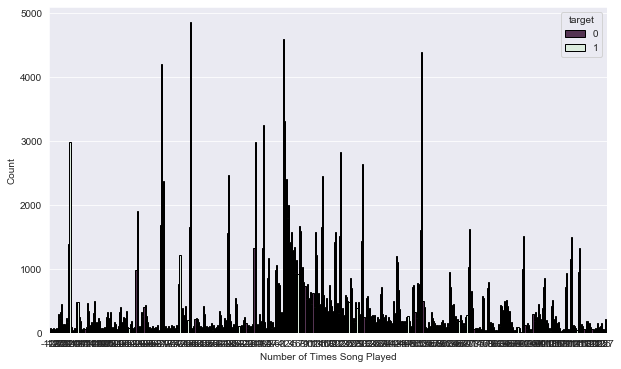

In [65]:
### Distrubution of Target Values
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
#
sn.countplot(x="count_song_played", data = df
              , palette = sn.cubehelix_palette(2, start=1, rot=-.75, dark=0.25, light=.9, reverse=True)
              #, palette = sns.color_palette("tab10") ,linewidth=1
              , edgecolor = "black"
              , hue = "target"
              #, order = df['source_type'].value_counts().index
             )
plt.ylabel("Count")
plt.xlabel("Number of Times Song Played")
#plt.xticks(rotation=45)
plt.show()

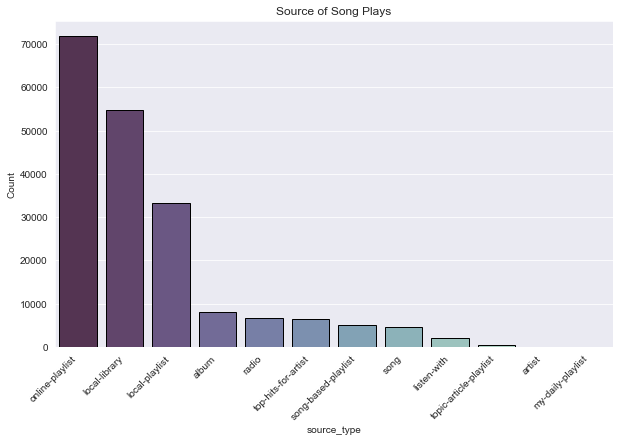

In [67]:
### Chart for sources
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
sn.countplot(x="source_type", data = df
              , palette = sn.cubehelix_palette(12, start=1, rot=-.75, dark=0.25, light=.9, reverse=True)
              #, palette = sns.color_palette("tab10") ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              , order = df['source_type'].value_counts().index
             )
plt.title('Source of Song Plays')
plt.ylabel("Count")
#plt.xlabel("Source of Song Event")
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('sources_count.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('source_count.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()


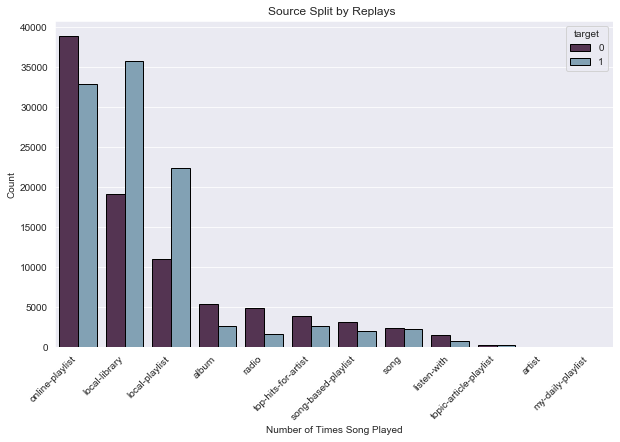

In [68]:
## Source Split by Target Value
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
sn.countplot(x="source_type", data = df
              , palette = sn.cubehelix_palette(2, start=1, rot=-.75, dark=0.25, light=.6, reverse=True)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              , hue = "target"
              , order = df['source_type'].value_counts().index)
plt.title("Source Split by Replays ")
plt.ylabel("Count")
plt.xlabel("Number of Times Song Played")
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('sources_trgt.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('source_trgt.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

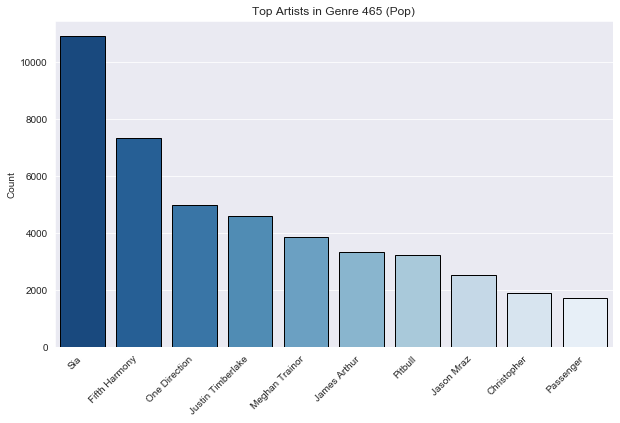

In [69]:
## Top ten artists in Genre 465 ('think this is Pop')
## can turn targets on or off
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
temp = df[df['genre_ids'] == '465']
sn.countplot(x="artist_name", data = temp
              , palette = sn.color_palette("Blues_r", n_colors = 10)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              #, order = df['genre_ids'].value_counts().index)
              ## limits to just the top 10 values  
              , order=temp.artist_name.value_counts().iloc[:10].index
             )
plt.title("Top Artists in Genre 465 (Pop)")
plt.ylabel("Count")
plt.xlabel("")
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('artists_pop.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('aartists_pop.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

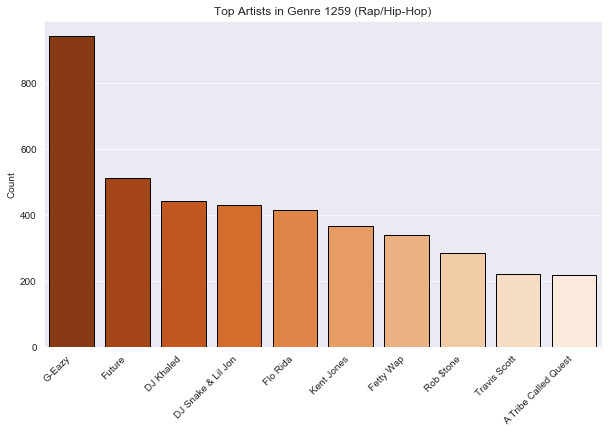

In [70]:
## Top ten artists in Genre 1259 ('Rap/Hip-Hop')
## can turn targets on or off
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
temp = df[df['genre_ids'] == '1259']
sn.countplot(x="artist_name", data = temp
              , palette = sn.color_palette("Oranges_r", n_colors = 10)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              #, order = df['genre_ids'].value_counts().index)
              ## limits to just the top 10 values  
              , order=temp.artist_name.value_counts().iloc[:10].index
             )
plt.title("Top Artists in Genre 1259 (Rap/Hip-Hop)")
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('artists_rap.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('aartists_rap.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

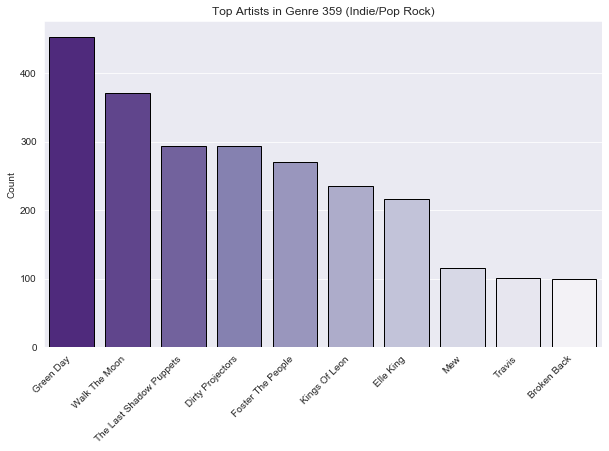

In [71]:
## Top ten artists in Genre 359 ('Indie/Pop/Rock')
## can turn targets on or off
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
temp = df[df['genre_ids'] == '359']
sn.countplot(x="artist_name", data = temp
              , palette = sn.color_palette("Purples_r", n_colors = 10)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              #, order = df['genre_ids'].value_counts().index)
              ## limits to just the top 10 values  
              , order=temp.artist_name.value_counts().iloc[:10].index
             )
plt.title("Top Artists in Genre 359 (Indie/Pop Rock)")
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('artists_indie.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('aartists_indie.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

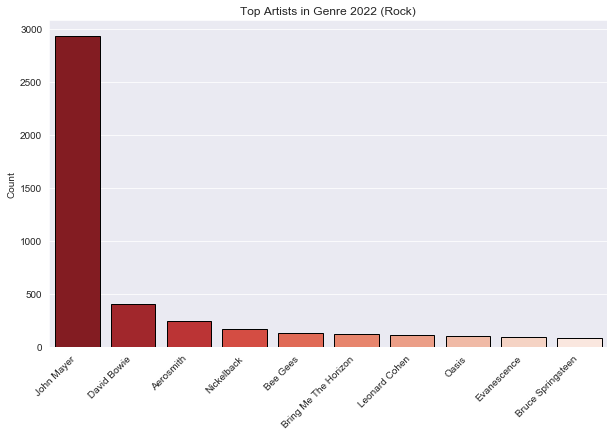

In [72]:
## Top ten artists in Genre 2022 ('Rock')
## can turn targets on or off
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
temp = df[df['genre_ids'] == '2022']
sn.countplot(x="artist_name", data = temp
              , palette = sn.color_palette("Reds_r", n_colors = 10)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              #, order = df['genre_ids'].value_counts().index)
              ## limits to just the top 10 values  
              , order=temp.artist_name.value_counts().iloc[:10].index
             )
plt.title("Top Artists in Genre 2022 (Rock)")
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45,horizontalalignment='right')
plt.savefig('artists_rock.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('aartists_rock.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

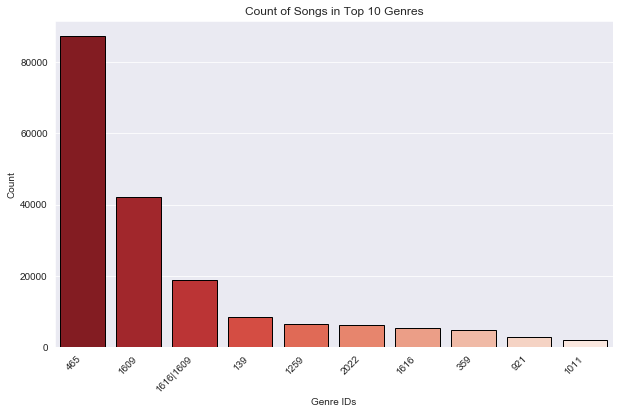

In [73]:
## Top 10 Genres
## can turn targets on or off
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
sn.countplot(x="genre_ids", data = df
              , palette = sn.color_palette("Reds_r", n_colors = 10)
              #, palette = sns.color_palette("tab10", n_colors=8) ,linewidth=1
              , edgecolor = "black"
              #, hue = "target"
              #, order = df['genre_ids'].value_counts().index)
              ## limits to just the top 10 values  
              , order=df.genre_ids.value_counts().iloc[:10].index)
plt.title("Count of Songs in Top 10 Genres")
plt.ylabel("Count")
plt.xlabel("Genre IDs")
plt.xticks(rotation=45, horizontalalignment='right')
plt.savefig('top10_genres.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('top10_genres.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

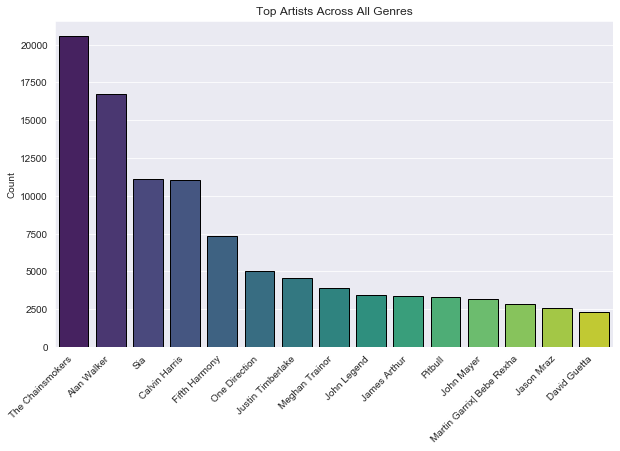

In [74]:
### Top 15 Artists in Any Genre
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
#temp = art_tab[1:16] # specifically scoping out Various
sn.barplot(x = 'artist_name', y = 'count', data=art_tab[:15]
            #, palette = sns.cubehelix_palette(15, reverse = True)
            #, hue = "genre_id"
            , palette = "viridis"
            #, palette = "tab10"
            , linewidth=1
            , edgecolor = 'black'
           ) 
#df['count_song_played'].agg(['sum'])
plt.title("Top Artists Across All Genres")
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45,horizontalalignment='right')
plt.savefig('top15_artists.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('top15_artists.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

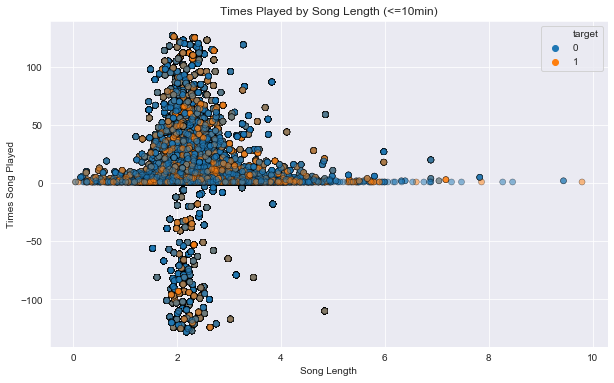

In [76]:
## Swarmplot showing relationship between 
## song length and how often a song is playued
###########!!!!!!!!!!!!!!!!!#################
##########     WARNING #####################
## This takes extremley long to run
## need to subset since there are some outliers on song length
## going to set this at max of 10minutes
## also, do not save this as a PDF, it will crash
temp = []
temp  = df[df['song_length'] <= 10]
#temp = temp[temp['target'] == 1]
#temp = temp[temp['genre_ids'] == '465']
plt.figure(figsize=(10,6))
sn.set_style('darkgrid')
#sns.lmplot(x='count_song_played', y='song_length', data=df, height = 7)
sn.scatterplot(y = 'count_song_played'
                , x = 'song_length'
                , data = temp
                #, color = 'lightgreen'
                , hue = "target"
                , alpha = 0.5
                , edgecolor= 'black'
                , linewidth = 0.5
                #, dodge = True
               )
plt.title("Times Played by Song Length (<=10min)")
plt.xlabel('Song Length')
plt.ylabel('Times Song Played')
plt.savefig('len_count_swarm.png',bbox_inches = 'tight', dpi = 300)
plt.show()

In [ ]:
######################################################
### ALL Artists Wordcloud
######################################################
rn.seed(76559)
names = []
names = df[['artist_name', 'genre_ids', 'count_song_played']]
### to subset set a specific genre below
# comments out if not wanted
#names = names[names['genre_ids'] == '2022']
#names = names[names['count_song_played'] >= 50]
#names = names[:5000]
names.reset_index()
### Need to strip middle space
names['artist_name'] = names['artist_name'].str.replace(" ","")
names['artist_name'] = names['artist_name'].str.replace("-","")
names['artist_name'] = names['artist_name'].str.replace(".","")
names['artist_name'] = names['artist_name'].str.replace("$","")
names['artist_name'] = names['artist_name'].str.strip()

text = " ".join(name for name in names.artist_name)
print ("There are {} words in the combination of all artist names.".format(len(text)))
len(text)
# Generate a word cloud image
rn.seed(76559)
wordcloud = WordCloud(max_words = 50
                      #, colormap = sns.cubehelix_palette(15, reverse = True)
                      , background_color = "black"
                      , scale = 10
                      , relative_scaling = 0
                      , collocations = False
                      ).generate(text)
# Display the generated image:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('all_wordcloud.png',bbox_inches = 'tight', dpi = 300)
plt.savefig('all_wordcloud.pdf',bbox_inches = 'tight', dpi = 300)
plt.show()

## Prioritize Features

In [77]:
train_filename = 'df_train_clean.csv'
test_filename = 'df_test_clean.csv'
train = pd.read_csv(train_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)
test = pd.read_csv(test_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)

#train = df_train_clean.copy()
#test = df_test_clean.copy()

#train = train.take(np.random.permutation(len(train))[:200000])
#test = test.take(np.random.permutation(len(test))[:100000])

In [78]:
df = train.copy()
df_target = train.copy()
df_train = train.copy()
# datetime data to category
for col in df.select_dtypes(include=['timedelta64[ns]']).columns:
    df[col] = df[col].astype('category')
    
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes
    
df = df.drop(['msno', 'song_id'], axis=1)

In [79]:
# Model with the best estimator
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df_target.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

In [ ]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [ ]:
df_Analysis = df_target.drop(df_plot.features[df_plot.importances < 0.05].tolist(), 1)
df_Analysis.columns

In [ ]:
train = train[['source_type', 'song_length', 'composer', 'lyricist', 'city', 'age', 'membership_days', 'count_song_played', 'target']]
test = test[['source_type', 'song_length', 'composer', 'lyricist', 'city', 'age', 'membership_days', 'count_song_played']]

## Train and Test Model

In [84]:
#####################################################
###       Copy Clean Data into Dataframes        ####
#####################################################

train_filename = 'df_train_clean.csv'
test_filename = 'df_test_clean.csv'
train = pd.read_csv(train_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)
test = pd.read_csv(test_filename, encoding = 'utf-8', na_values=['NaN'], index_col = 0)


In [85]:
# datetime, registered_via and age data to category
train.age = train['age'].astype('category')
train.city = train['city'].astype('category')
test.age = test['age'].astype('category')
test.city = test['city'].astype('category')


for col in train.columns:
    if train[col].dtypes == object:
        train[col] = train[col].astype('category')
    if train[col].dtype == 'timedelta64[ns]':
        train[col] = train[col].astype('int64')    
        
for col in test.columns:
    if test[col].dtypes == object:
        test[col] = test[col].astype('category')
    if test[col].dtypes == 'timedelta64[ns]':
        test[col] = test[col].astype('int64')   
        
# Encoding categorical features
for col in train.select_dtypes(include=['category']).columns:
    train[col] = train[col].cat.codes
    
train = train.drop(['msno', 'song_id'], axis=1)
test = test.drop(['msno', 'song_id'], axis=1)

In [86]:
#####################################################
####       Create Training/Test Split            ####
#####################################################
target = train.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(train, target, test_size = 0.3)

In [88]:
%%time
#####################################################
####         Randon Forest Classifier            ####
#####################################################
# Create model
print('Training Model')
model1 = RandomForestClassifier(n_estimators=350, max_depth=40)
model1.fit(train_data, train_labels)

# Predicting
print('Predicting Values')
predict_labels1 = model1.predict(test_data)

Training Model
Predicting Values
Wall time: 2min 23s


In [89]:
print(metrics.classification_report(test_labels, predict_labels1))
#print("R^2 value = {}".format(metrics.r2_score(test_labels, predict_labels1)))


              precision    recall  f1-score   support

           0       0.63      0.59      0.61     27075
           1       0.66      0.70      0.68     31113

    accuracy                           0.65     58188
   macro avg       0.65      0.65      0.65     58188
weighted avg       0.65      0.65      0.65     58188



In [90]:
#test_labels

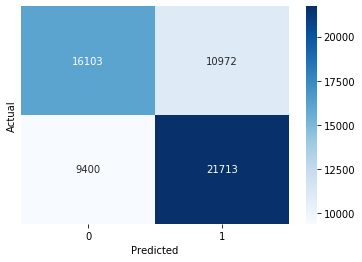

In [91]:
cm = metrics.confusion_matrix(test_labels, predict_labels1)
sn.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=True, yticklabels=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

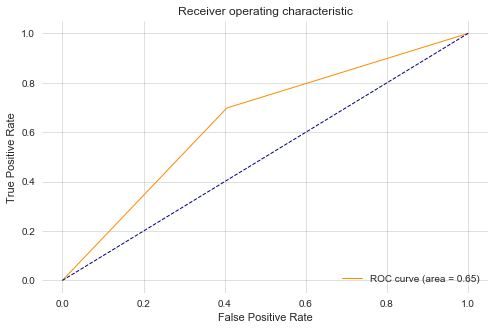

In [92]:
fpr, tpr, thresholds = roc_curve(test_labels, predict_labels1)
roc_auc = auc(fpr, tpr)


plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('w')
ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.show()

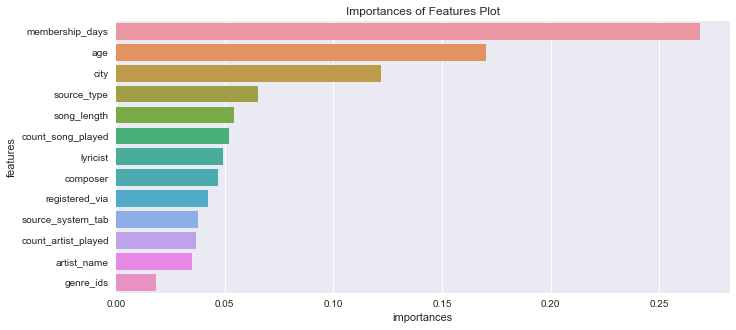

In [93]:
df_plot = pd.DataFrame({'features': train_data.columns,
                        'importances': model1.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)
plt.figure(figsize=[11,5])
sn.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [94]:
%%time

# Create model
print('Training Model')
model2 = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=300)
model2.fit(train_data, train_labels)

# Predicting
print('Predicting Values')
predict_labels2 = model2.predict(test_data)

Training Model
Predicting Values
Wall time: 58.6 s


              precision    recall  f1-score   support

           0       0.70      0.63      0.66     27075
           1       0.70      0.76      0.73     31113

    accuracy                           0.70     58188
   macro avg       0.70      0.70      0.70     58188
weighted avg       0.70      0.70      0.70     58188

R^2 value = -0.20550295754204173


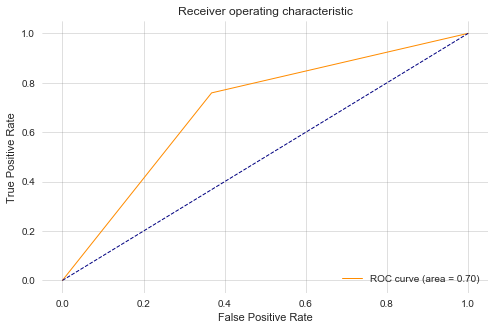

In [95]:
print(metrics.classification_report(test_labels, predict_labels2))
print("R^2 value = {}".format(metrics.r2_score(test_labels, predict_labels2)))
fpr, tpr, thresholds = roc_curve(test_labels, predict_labels2)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('w')
ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.show()

<Figure size 1440x360 with 0 Axes>

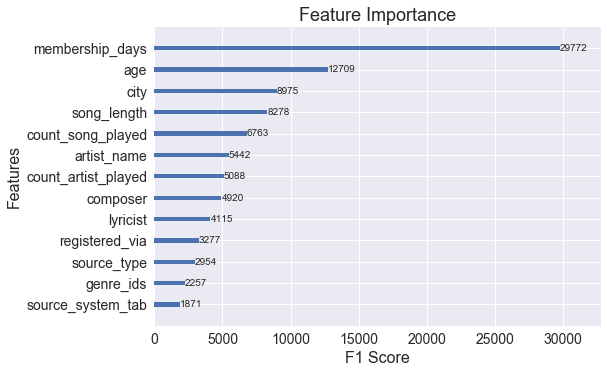

In [96]:
from xgboost import plot_importance
plt.style.use('seaborn')
plt.figure(figsize=[20,5])
xgb.plot_importance(model2)
plt.title('Feature Importance', fontsize= 18)
plt.xlabel('F1 Score', fontsize= 16)
plt.ylabel('Features', fontsize= 16)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.show()


In [97]:
%%time

# Create model
print('Training Model')
model3 = CatBoostClassifier(learning_rate=0.1, depth=10, iterations=300,)
model3.fit(train_data, train_labels)
res = model3.calc_feature_statistics(train_data,
                                    train_labels,
                                    feature=2,
                                    plot=True)

# Predicting
print('Predicting Values')
predict_labels3 = model3.predict(test_data)

Training Model
0:	learn: 0.6818825	total: 179ms	remaining: 53.6s
1:	learn: 0.6726686	total: 287ms	remaining: 42.8s
2:	learn: 0.6648170	total: 405ms	remaining: 40.1s
3:	learn: 0.6584241	total: 519ms	remaining: 38.4s
4:	learn: 0.6533304	total: 633ms	remaining: 37.3s
5:	learn: 0.6489956	total: 757ms	remaining: 37.1s
6:	learn: 0.6459349	total: 882ms	remaining: 36.9s
7:	learn: 0.6430929	total: 986ms	remaining: 36s
8:	learn: 0.6402728	total: 1.09s	remaining: 35.4s
9:	learn: 0.6380180	total: 1.21s	remaining: 35s
10:	learn: 0.6359687	total: 1.31s	remaining: 34.5s
11:	learn: 0.6341134	total: 1.42s	remaining: 34.1s
12:	learn: 0.6324549	total: 1.53s	remaining: 33.9s
13:	learn: 0.6314163	total: 1.64s	remaining: 33.4s
14:	learn: 0.6303496	total: 1.74s	remaining: 33s
15:	learn: 0.6292193	total: 1.85s	remaining: 32.8s
16:	learn: 0.6280193	total: 1.96s	remaining: 32.5s
17:	learn: 0.6271194	total: 2.06s	remaining: 32.3s
18:	learn: 0.6262151	total: 2.18s	remaining: 32.2s
19:	learn: 0.6252179	total: 2.29

162:	learn: 0.5694821	total: 18.6s	remaining: 15.6s
163:	learn: 0.5691904	total: 18.7s	remaining: 15.5s
164:	learn: 0.5688190	total: 18.8s	remaining: 15.4s
165:	learn: 0.5686515	total: 18.9s	remaining: 15.3s
166:	learn: 0.5684293	total: 19.1s	remaining: 15.2s
167:	learn: 0.5682181	total: 19.2s	remaining: 15.1s
168:	learn: 0.5679328	total: 19.3s	remaining: 14.9s
169:	learn: 0.5676782	total: 19.4s	remaining: 14.8s
170:	learn: 0.5674021	total: 19.5s	remaining: 14.7s
171:	learn: 0.5671199	total: 19.6s	remaining: 14.6s
172:	learn: 0.5668147	total: 19.7s	remaining: 14.4s
173:	learn: 0.5665696	total: 19.8s	remaining: 14.3s
174:	learn: 0.5662057	total: 19.9s	remaining: 14.2s
175:	learn: 0.5659742	total: 20s	remaining: 14.1s
176:	learn: 0.5657509	total: 20.1s	remaining: 14s
177:	learn: 0.5651852	total: 20.2s	remaining: 13.8s
178:	learn: 0.5648674	total: 20.3s	remaining: 13.7s
179:	learn: 0.5645272	total: 20.4s	remaining: 13.6s
180:	learn: 0.5643393	total: 20.5s	remaining: 13.5s
181:	learn: 0.56

Predicting Values
Wall time: 59.8 s


              precision    recall  f1-score   support

           0       0.68      0.59      0.63     27075
           1       0.68      0.76      0.72     31113

    accuracy                           0.68     58188
   macro avg       0.68      0.67      0.67     58188
weighted avg       0.68      0.68      0.68     58188

R^2 value = -0.2854231341336153


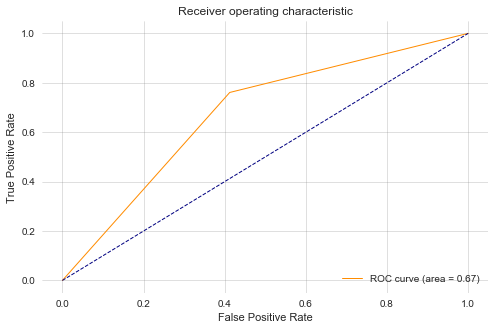

In [98]:
print(metrics.classification_report(test_labels, predict_labels3))
print("R^2 value = {}".format(metrics.r2_score(test_labels, predict_labels3)))
fpr, tpr, thresholds = roc_curve(test_labels, predict_labels3)
roc_auc = auc(fpr, tpr)

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('w')
ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.show()

In [99]:
print(model3.get_feature_importance(prettified=True, verbose=True))

             Feature Id  Importances
0           source_type    14.459462
1       membership_days    12.886481
2                   age    11.350275
3                  city    10.373122
4     count_song_played     7.666159
5     source_system_tab     7.111306
6           song_length     5.977219
7   count_artist_played     5.951682
8        registered_via     5.567216
9           artist_name     5.340049
10            genre_ids     4.893862
11             lyricist     4.515386
12             composer     3.907783


In [100]:
%%time
nv = GaussianNB() # create a classifier
nv.fit(train_data, train_labels) # fitting the data
predict_labels4 = nv.predict(test_data) # store the prediction data

Wall time: 144 ms


              precision    recall  f1-score   support

           0       0.60      0.46      0.52     27075
           1       0.61      0.74      0.67     31113

    accuracy                           0.61     58188
   macro avg       0.61      0.60      0.59     58188
weighted avg       0.61      0.61      0.60     58188

R^2 value = -0.5758849686777527


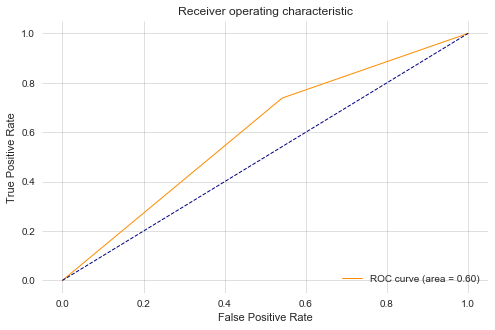

In [101]:
print(metrics.classification_report(test_labels, predict_labels4))
print("R^2 value = {}".format(metrics.r2_score(test_labels, predict_labels4)))
fpr, tpr, thresholds = roc_curve(test_labels, predict_labels4)
roc_auc = auc(fpr, tpr)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_facecolor('w')
ax.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.show()

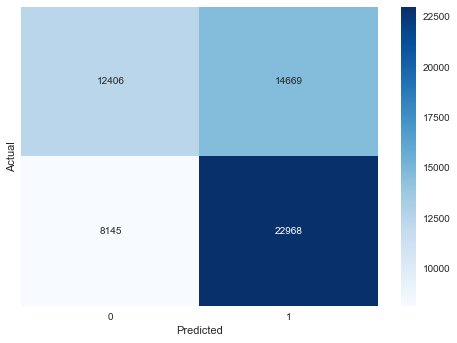

In [102]:
cm = metrics.confusion_matrix(test_labels, predict_labels4)
sn.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=True, yticklabels=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()